# Pandas IO

## Importando bibliotecas

In [64]:
import pandas as pd
import numpy as np
import html5lib
import lxml
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table

## Importando nomes

In [2]:
nomes_f = pd.read_json("https://servicodados.ibge.gov.br/api/v1/censos/nomes/ranking?qtd=200&sexo=f")
nomes_m = pd.read_json("https://servicodados.ibge.gov.br/api/v1/censos/nomes/ranking?qtd=200&sexo=m")

frames = [nomes_f, nomes_m]
nomes = pd.concat(frames)['nome'].to_frame()

print("Quantidade de nomes: "+str(len(nomes_f) + len(nomes_m)))

Quantidade de nomes: 400


## Incluindo ID dos alunos

In [13]:
np.random.seed(123)

total_alunos = len(nomes)

nomes["id_aluno"] = np.random.permutation(total_alunos) + 1

## Incluindo emails

In [4]:
dominios = ['@dominiodoemail.com.br', '@servicodoemail.br']
nomes['dominio'] = np.random.choice(dominios, total_alunos)

nomes['email'] = nomes.nome.str.cat(nomes.dominio).str.lower()

## Inclusão de cursos

In [5]:
url = 'http://tabela-cursos.herokuapp.com/index.html'
cursos = pd.read_html(url)
cursos = cursos[0]

#Alterando o nome da coluna
cursos.rename(columns={'Nome do curso': 'nome_do_curso'}, inplace = True)

# Alterando o index de cursos
cursos['id'] = cursos.index+1
cursos = cursos.set_index('id')

## Matriculando alunos nos cursos

In [55]:
nomes["matriculas"] = np.ceil(np.random.exponential(size=total_alunos) * 1.5).astype(int)

0.09932115335268325

In [7]:
nomes.matriculas.describe()

count    400.000000
mean       2.137500
std        1.511392
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        9.000000
Name: matriculas, dtype: float64

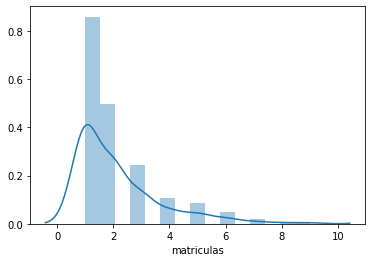

In [8]:
sns.distplot(nomes.matriculas)

In [9]:
nomes.matriculas.value_counts()

1    183
2    106
3     52
4     23
5     18
6     10
7      4
9      2
8      2
Name: matriculas, dtype: int64

## Selecionando cursos

In [34]:
todas_matriculas = []
x = np.random.rand(20)
prob = x / sum(x)

for index, row in nomes.iterrows():
    id = row.id_aluno
    matriculas = row.matriculas
    
    for i in range(matriculas):
        mat = [id, np.random.choice(cursos.index, p = prob)]
        todas_matriculas.append(mat)
        
matriculas = pd.DataFrame(todas_matriculas, columns = ['id_aluno', 'id_curso'])   
    

In [45]:
matriculas_por_curso = matriculas.groupby('id_curso').count().join(cursos['nome_do_curso']).rename(columns={'id_aluno': 'quantidade_alunos'})

In [40]:
nomes.sample(5)

,nome,id_aluno,dominio,email,matriculas
73,MARCO,270,@dominiodoemail.com.br,marco@dominiodoemail.com.br,1
47,LUCIA,241,@dominiodoemail.com.br,lucia@dominiodoemail.com.br,2
65,MAURICIO,395,@servicodoemail.br,mauricio@servicodoemail.br,3
112,TATIANA,161,@dominiodoemail.com.br,tatiana@dominiodoemail.com.br,1
126,MURILO,269,@dominiodoemail.com.br,murilo@dominiodoemail.com.br,2


In [43]:
cursos.head()

,nome_do_curso
id,
1,Lógica de programação
2,Java para Web
3,C# para Web
4,Ruby on Rails
5,Cursos de Python


In [44]:
matriculas

,id_aluno,id_curso
0,235,12
1,235,7
2,235,7
3,43,20
4,304,13
...,...,...
850,323,14
851,383,15
852,383,3
853,383,10


In [59]:
matriculas_por_curso.to_csv('dados/matriculas_por_curso.csv', sep=',', index = False)

matriculas_json = matriculas_por_curso.to_json()
matriculas_html = matriculas_por_curso.to_html()

In [61]:
print(matriculas_html)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>quantidade_alunos</th>
      <th>nome_do_curso</th>
    </tr>
    <tr>
      <th>id_curso</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>5</td>
      <td>Lógica de programação</td>
    </tr>
    <tr>
      <th>2</th>
      <td>93</td>
      <td>Java para Web</td>
    </tr>
    <tr>
      <th>3</th>
      <td>90</td>
      <td>C# para Web</td>
    </tr>
    <tr>
      <th>4</th>
      <td>10</td>
      <td>Ruby on Rails</td>
    </tr>
    <tr>
      <th>5</th>
      <td>7</td>
      <td>Cursos de Python</td>
    </tr>
    <tr>
      <th>6</th>
      <td>47</td>
      <td>PHP com MySql</td>
    </tr>
    <tr>
      <th>7</th>
      <td>51</td>
      <td>.NET para web</td>
    </tr>
    <tr>
      <th>8</th>
      <td>59</td>
      <td>Novas integrações com Java</td>
    </tr>
    <tr>
      <th>9</th>
      <td>3</td>
      

## Banco de Dados

In [68]:
engine = create_engine("sqlite:///:memory:")

In [69]:
type(engine)

sqlalchemy.engine.base.Engine

In [70]:
matriculas_por_curso.to_sql('matriculas', engine)
print(engine.table_names())

In [73]:
pd.read_sql('select * from matriculas', engine)

,id_curso,quantidade_alunos,nome_do_curso
0,1,5,Lógica de programação
1,2,93,Java para Web
2,3,90,C# para Web
3,4,10,Ruby on Rails
4,5,7,Cursos de Python
5,6,47,PHP com MySql
6,7,51,.NET para web
7,8,59,Novas integrações com Java
8,9,3,TDD com Java
9,10,27,Código limpo com C#


In [74]:
pd.read_sql_table('matriculas', engine, columns = ['nome_do_curso','quantidade_alunos'])

,nome_do_curso,quantidade_alunos
0,Lógica de programação,5
1,Java para Web,93
2,C# para Web,90
3,Ruby on Rails,10
4,Cursos de Python,7
5,PHP com MySql,47
6,.NET para web,51
7,Novas integrações com Java,59
8,TDD com Java,3
9,Código limpo com C#,27
